In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
import os

In [2]:
# Parameter
img_width, img_height = 150, 150
batch_size = 32
num_classes = 7 # jumlah kelas

# Direktori data
train_data_dir = 'D:\penelitian arya\dataset\Train'
validation_data_dir = 'D:\penelitian arya\dataset\Valid'



<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
C:\Users\PC-04\AppData\Local\Temp\ipykernel_6264\3212889082.py:7: SyntaxWarning: invalid escape sequence '\p'
  train_data_dir = 'D:\penelitian arya\dataset\Train'
C:\Users\PC-04\AppData\Local\Temp\ipykernel_6264\3212889082.py:8: SyntaxWarning: invalid escape sequence '\p'
  validation_data_dir = 'D:\penelitian arya\dataset\Valid'


In [3]:
# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk membaca gambar dari direktori dataset
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical' # Menggunakan categorical untuk klasifikasi multiklas
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


print("Class indices:", train_generator.class_indices)

Found 748 images belonging to 7 classes.
Found 497 images belonging to 7 classes.
Class indices: {'Resize Buah_cabai_sehat': 0, 'resize_Buah Sakit': 1, 'resize_Daun sehat': 2, 'resize_kutu kebul': 3, 'resize_virus gemini': 4, 'resize_virus keriting': 5, 'resize_virus mosaic': 6}


In [4]:
# Menggunakan Pre-trained Model (Transfer Learning)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False


In [5]:
# Membangun model CNN
model = Sequential([

# mengambil ekstraksi fitur seperti warna RGB secara otomatis 
# melalui Conv2D atau lapisan Convolusi pertama
base_model,
GlobalAveragePooling2D(),  # Mengganti Flatten dengan GlobalAveragePooling2D
Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
Dropout(0.5),
Dense(num_classes, activation='softmax')
# Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
# MaxPooling2D(pool_size=(2, 2)),

# lapisan Convolusi ke dua
# Conv2D(64, (3, 3), activation='relu'),
# MaxPooling2D(pool_size=(2, 2)),

# lapisan Convolusi ke tiga
# Conv2D(128, (3, 3), activation='relu'),
# MaxPooling2D(pool_size=(2, 2)),

# lapisan Convolusi ke empat
# Conv2D(256, (3, 3), activation='relu'),
# MaxPooling2D(pool_size=(2, 2)),

# # lapisan untuk meratakan hasil Convolusi menjadi 1 dimensi
# model.add(Flatten()),
# model.add(Dense(512, activation='relu')),
# model.add(Dropout(0.5)),

# # lapisan output
# model.add(Dense(1, activation='sigmoid'))

# Flatten lapisan untuk meratakan hasil konvolusi menjadi satu dimensi
# Flatten(), 
# Lapisan dense pertama
# Dense(512, activation='relu'),
# Dropout(0.5),
    
# Lapisan output
# Dense(num_classes, activation='softmax')  # Menggunakan softmax untuk klasifikasi multiklas
])

# lapisan untuk mengkompilasi atau menjalankan model
# model.compile(loss='binary_crossentropy',
            #   optimizer='adam',
            #   metrics=['accuracy'])
optimizer = Adam(learning_rate=0.0001)  # Mengatur learning rate
model.compile(optimizer=optimizer, 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()

# Callbacks
# Early stopping atau pemberhentian secara otomatis 
# jika model yang di train tidak kunjung mengalami peningkatan dalam accuracy-nya
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
# Melatih model
history = model.fit(
    train_generator,
    epochs = 50,
    # steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50


c:\Users\PC-04\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2039 - loss: 7.0049 - val_accuracy: 0.2334 - val_loss: 6.5943 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2858 - loss: 6.5619 - val_accuracy: 0.2515 - val_loss: 6.2344 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.3113 - loss: 6.1480 - val_accuracy: 0.2636 - val_loss: 5.9006 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3449 - loss: 5.8182 - val_accuracy: 0.2978 - val_loss: 5.6113 - learning_rate: 1.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3374 - loss: 5.5416 - val_accuracy: 0.3642 - val_loss: 5.3217 - learning_rate: 1.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3549 - loss: 5.2603 - val_accuracy: 0.3662 - val_loss: 5.0685 - learning_rate: 1.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3481 - loss: 5.0093 - v

In [7]:
# Menyimpan model
model.save('plant_disease_cnn.h5')

<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
<>:34: SyntaxWarning: invalid escape sequence '\p'
<>:35: SyntaxWarning: invalid escape sequence '\p'
C:\Users\PC-04\AppData\Local\Temp\ipykernel_6264\2760858992.py:34: SyntaxWarning: invalid escape sequence '\p'
  folder_path = 'D:\penelitian arya\Tes'
C:\Users\PC-04\AppData\Local\Temp\ipykernel_6264\2760858992.py:35: SyntaxWarning: invalid escape sequence '\p'
  model_path = 'D:\penelitian arya\plant_disease_cnn.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


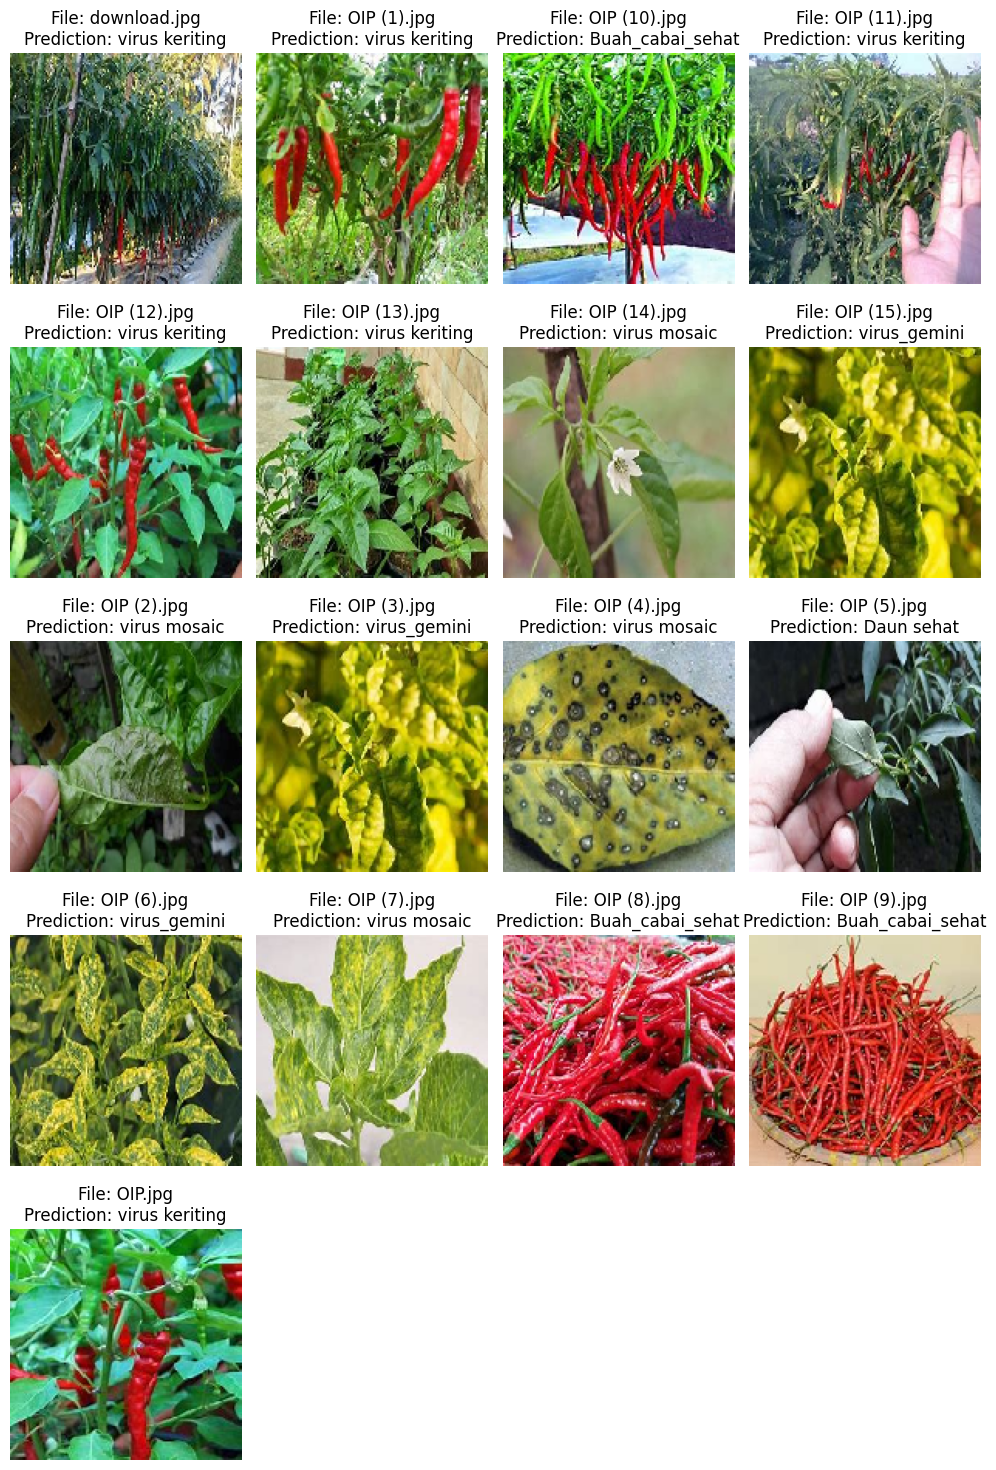

In [15]:
# Fungsi untuk memprediksi gambar dan menampilkannya dalam grid
def predict_and_show_images_in_folder(folder_path, model, class_labels):
    try:
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpeg', '.png', '.jpg'))]
        num_images = len(image_files)
        num_columns = 4
        num_rows = num_images // num_columns + (num_images % num_columns != 0)
        
        plt.figure(figsize=(10, num_rows * 3))
        
        for i, filename in enumerate(image_files):
            image_path = os.path.join(folder_path, filename)
            img = load_img(image_path, target_size=(img_width, img_height))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 254.0

            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            result = class_labels[predicted_class]

            plt.subplot(num_rows, num_columns, i + 1)
            plt.imshow(img)
            plt.title(f'File: {filename}\nPrediction: {result}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

# pemanggilan folder input & model
folder_path = 'D:\penelitian arya\Tes'  
model_path = 'D:\penelitian arya\plant_disease_cnn.h5'  
img_width, img_height = 150, 150

# Daftar label kelas 
class_labels = ['Buah_cabai_sehat', 'Buah Sakit', 'Daun sehat', 'kutu kebul',
                'virus_gemini', 'virus keriting', 'virus mosaic']  

# Memuat model
model = load_model(model_path)

# Memanggil fungsi predict_and_show_images_in_folder
predict_and_show_images_in_folder(folder_path, model, class_labels)

In [16]:
# Menampilkan grafik akurasi dan loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(7, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

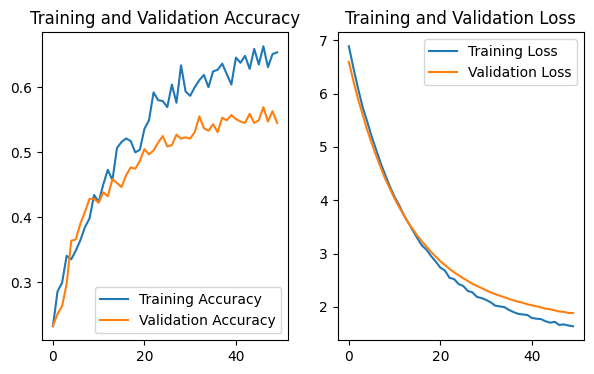

In [17]:
# Plot training history
plot_training_history(history)

In [ ]:
# Evaluasi model pada data validasi dan hitung metrik
# def evaluate_model_on_validation(model, validation_generator):
#     validation_generator.reset()
#     Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
#     y_pred = np.where(Y_pred > 0.5, 1, 0)  # Binarize predictions
#     y_true = validation_generator.classes  # True labels

#     print('Confusion Matrix')
#     print(confusion_matrix(y_true, y_pred))

#     print('Classification Report')
#     target_names = ['Healthy', 'Diseased']
#     print(classification_report(y_true, y_pred, target_names=target_names))

# Evaluasi model dan tampilkan metrik
# evaluate_model_on_validation(model, validation_generator)

In [18]:
def evaluate_model_on_validation(model, validation_generator):
    # Reset generator
    validation_generator.reset()
    
    # Mendapatkan prediksi dari model
    Y_pred = model.predict(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
    
    # Mendapatkan indeks dengan probabilitas tertinggi untuk setiap prediksi
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Mendapatkan label asli
    y_true = validation_generator.classes

    # Confusion Matrix
    print('Confusion Matrix')
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    # Classification Report
    print('Classification Report')
    target_names = list(validation_generator.class_indices.keys())  # Mendapatkan nama kelas dari generator
    print(classification_report(y_true, y_pred, target_names=target_names))

# Evaluasi model dan tampilkan metrik
evaluate_model_on_validation(model, validation_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step
Confusion Matrix
[[20  0  7  7  7 53 14]
 [ 1  0  4  1  0  8  1]
 [19  0  7  3  4 46  9]
 [10  0  2  3  2 22  9]
 [14  0  8  5  5 30  8]
 [23  1  6 13 10 66 19]
 [ 6  0  6  0  0 14  4]]
Classification Report
                         precision    recall  f1-score   support

Resize Buah_cabai_sehat       0.22      0.19      0.20       108
      resize_Buah Sakit       0.00      0.00      0.00        15
      resize_Daun sehat       0.17      0.08      0.11        88
      resize_kutu kebul       0.09      0.06      0.07        48
    resize_virus gemini       0.18      0.07      0.10        70
  resize_virus keriting       0.28      0.48      0.35       138
    resize_virus mosaic       0.06      0.13      0.09        30

               accuracy                           0.21       497
              macro avg       0.14      0.14      0.13       497
           weighted avg       0.19      0.21      0.19       497

